In [12]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
import sys; sys.path.append('/home/pshah/Documents/code/Vape/utils')
import alloptical_utils_pj as ao
import numpy as np
import utils_funcs as uf
import matplotlib.pyplot as plt
%run ./setup_notebook.ipynb
print(sys.path)

plt.rcParams['figure.figsize'] = [20.0, 3.0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/home/pshah/Documents/code/Vape/jupyter', '/home/pshah/anaconda3/lib/python37.zip', '/home/pshah/anaconda3/lib/python3.7', '/home/pshah/anaconda3/lib/python3.7/lib-dynload', '', '/home/pshah/anaconda3/lib/python3.7/site-packages', '/home/pshah/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/pshah/.ipython', '/home/pshah/Documents/code/Vape/utils', '/home/pshah/Documents/code/Vape/', '/home/pshah/Documents/code/Vape/', '/home/pshah/Documents/code/Vape/utils', '/home/pshah/Documents/code/Vape/utils', '/home/pshah/Documents/code/Vape/', '/home/pshah/Documents/code/Vape/utils']


In [13]:
paths = []
tiffs_loc = '/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_t-016'
tiffs_loc2 = '/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_t-016/2020-03-04_t-016_Cycle00001_Ch3.tif'
naparms_loc = '/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_classic_naparm_001'
paqs_loc = '/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_t-016.paq'

paths.append([tiffs_loc, naparms_loc, paqs_loc])
paths

[['/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_t-016',
  '/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_classic_naparm_001',
  '/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_t-016.paq']]

n planes: 1 
n frames: 4730 
fps: 15.222766231453363 
frame size (px): 1024 x 1024 
zoom: 0.795378456 
pixel size (um): 1.37329894729094 1.37329894729094 
scan centre (V): 0.0 0.0
tiff_path
naparm_path
paq_path
fps
frame_x
frame_y
n_planes
pix_sz_x
pix_sz_y
scan_x
scan_y
zoom
n_frames
stim_type
['/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_classic_naparm_001/2020-03-04_classic_naparm_001.gpl']
/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_classic_naparm_001/2020-03-04_classic_naparm_001.gpl
Single stim dur (ms): 10
Spiral size (um): 0.07388
['/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_classic_naparm_001/2020-03-04_classic_naparm_001.xml']
/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_classic_naparm_001/2020-03-04_classic_naparm_001.xml
Numbers of trials: 10 
Number of groups: 4 
Number of shots: 25 
Number of sequence reps: 1 
Inter-group delay: 5
n planes: 1 
n frames: 4730 
fps: 15.222766231453363 
frame size (px): 1024 x 1024 
zoom: 0.795378456 
pixel size (um): 1.37329

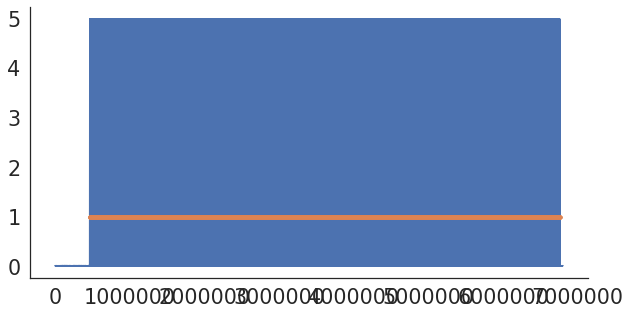

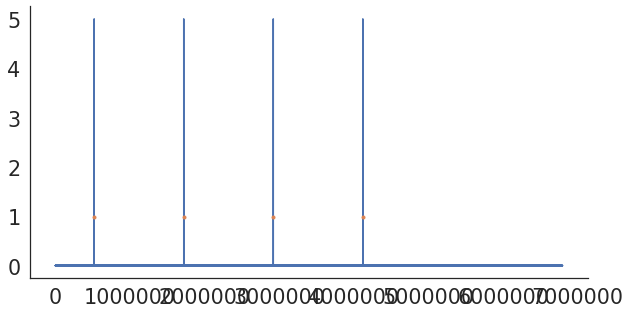

In [14]:
exp_obj = ao.alloptical(paths[0], stim='2pstim')
for key, values in vars(exp_obj).items():
    print(key)

exp_obj._parseNAPARMgpl()
exp_obj._parseNAPARMxml()
exp_obj._parsePVMetadata()
exp_obj.stimProcessing(stim_channel='markpoints2packio')

In [15]:
### figure out where the bad frames (i.e. photostimulation frames) are
bad_frames = []
for j in exp_obj.stim_start_frames[0]:
    for i in range(exp_obj.duration_frames+1): # usually need to remove 1 more frame than the stim duration, as the stim isn't perfectly aligned with the start of the imaging frame
        bad_frames.append(j+i)

np.save('%s/bad_frames.npy' % tiffs_loc, bad_frames)   # save to npy file and remember to move npy file to tiff folder before running with suite2p

print('/// New frame total:', exp_obj.n_frames-len(bad_frames), 'frames ///')


/// New frame total: 4710 frames ///


In [11]:
### make a new tiff file (not for suite2p) with the first photostim frame whitened, and save new tiff
tiff_path = '/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_t-014/2020-03-04_t-014_Cycle00001_Ch3.tif'

import tifffile as tf
im_stack = tf.imread(tiff_path, key=range(exp_obj.n_frames))


frames_to_whiten = []
for j in exp_obj.stim_start_frames[0]:
        frames_to_whiten.append(j)

im_stack_1 = im_stack
a = np.full_like(im_stack_1[0], fill_value=1001.01)
for frame in frames_to_whiten:
    im_stack_1[frame] = a

frames_to_remove = []
for j in exp_obj.stim_start_frames[0]:
    for i in range(1, exp_obj.duration_frames+1): # usually need to remove 1 more frame than the stim duration, as the stim isn't perfectly aligned with the start of the imaging frame
        frames_to_remove.append(j+i)

im_stack_1 = np.delete(im_stack, frames_to_remove, axis=0)

tf.imwrite("/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_t-014/2020-03-04_t014_artifactrem.tif",
           im_stack_1, photometric='minisblack')

# find the frames which are now photostim frames (relative to the new length after frames removed)
new_tiff = "/home/pshah/mnt/qnap/Data/2020-03-04/2020-03-04_t-014/2020-03-04_t014_artifactrem.tif"
new_stack = tf.imread(new_tiff, key=(range(len(im_stack_1))))

new_photostim_frames = []
for i in range(len(new_stack)):
    if new_stack[i][0][0]==1001:
        new_photostim_frames.append(i)

In [ ]:
## run suite2p now with the bad_frames.npy file to ignore bad frame



In [111]:
## Load up the suite2p processsed data - similar to basic vaping
s2p_path = '/home/pshah/mnt/qnap/Data/2020-02-17/t005_suite2p/plane0'

flu, spks, stat = uf.s2p_loader(s2p_path, subtract_neuropil=False)

flu = flu[:,:3600] # this is temporary until I figure what the hell is going on with suite2p cutting out frames improperly I think?? 

Loading 317 traces labelled as cells


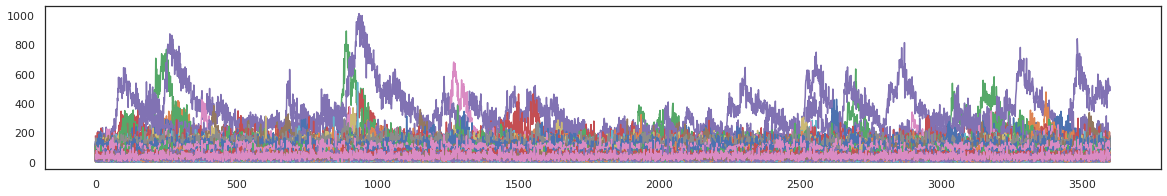

In [112]:
plt.figure(figsize=(20,3))
for i in range(len(stat)):
    plt.plot(flu[i])
#plt.plot(new_photostim_frames, np.ones(len(new_photostim_frames)), 'o')

In [54]:
###### find targetted cells (and also run suite2p processing)
exp_obj.s2pProcessing(s2p_path=s2p_path)
exp_obj._findTargets()

Loading 317 traces labelled as cells
Number of targets: 135
Searching for targeted cells...
Search completed.
Number of targeted cells:  54


In [114]:
target_cells = []
for i in exp_obj.targeted_cells:
    if i == 1:
        target_cells.append(True)
    else:
        target_cells.append(False)
        
# create flu_targeted cells object
flu_targets = flu[target_cells]

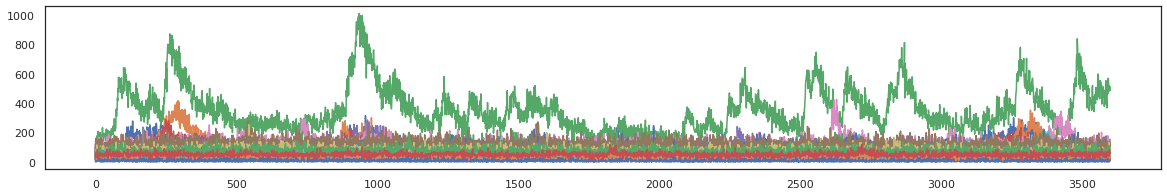

In [116]:
plt.figure(figsize=(20,3))
for i in range(len(flu_targets)):
    plt.plot(flu_targets[i])
#plt.plot(new_photostim_frames, np.ones(len(new_photostim_frames)), 'o', color='black')


In [158]:
dff = ao.normalize_dff(flu_targets)
dff = np.delete(dff, 50, 0) # cell 50 is just absolutely going offf.....

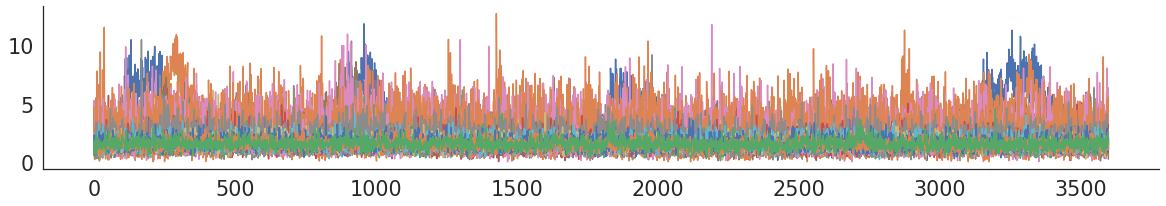

In [159]:
for i in range(len(dff)):
    plt.plot(dff[i])

### -------------------------------------------------------------------------------------------------------------------------------
### Seizure evoking photostim analysis

In [45]:
paths = []
tiff_loc = '/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM02_t-009'
tiff_loc2 = '/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM02_t-009/2020-02-26_XM02_t-009_Cycle00001_Ch3.tif'
naparms_loc = '/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM002_003'
paqs_loc = '/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM02_t-010.paq'

paths.append([tiff_loc, naparms_loc, paqs_loc])
paths

[['/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM02_t-009',
  '/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM002_003',
  '/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM02_t-010.paq']]

n planes: 1 
n frames: 148799 
fps: 15.266891445180585 
frame size (px): 1024 x 1024 
zoom: 1.0 
pixel size (um): 1.0922923963227 1.0922923963227 
scan centre (V): 0.0 0.0
tiff_path
naparm_path
paq_path
fps
frame_x
frame_y
n_planes
pix_sz_x
pix_sz_y
scan_x
scan_y
zoom
n_frames
stim_type
['/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM002_003/2020-02-26_XM002_003.gpl']
/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM002_003/2020-02-26_XM002_003.gpl
Single stim dur (ms): 10
Spiral size (um): 0.07388
['/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM002_003/2020-02-26_XM002_003.xml']
/home/pshah/mnt/qnap/Data/2020-02-26/2020-02-26_XM002_003/2020-02-26_XM002_003.xml
Numbers of trials: 10 
Number of groups: 3 
Number of shots: 1 
Number of sequence reps: 20 
Inter-group delay: 5
n planes: 1 
n frames: 148799 
fps: 15.266891445180585 
frame size (px): 1024 x 1024 
zoom: 1.0 
pixel size (um): 1.0922923963227 1.0922923963227 
scan centre (V): 0.0 0.0
['/home/pshah/mnt/qnap/Data/2020-02

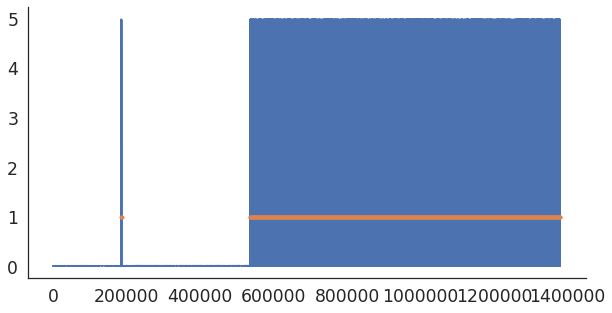

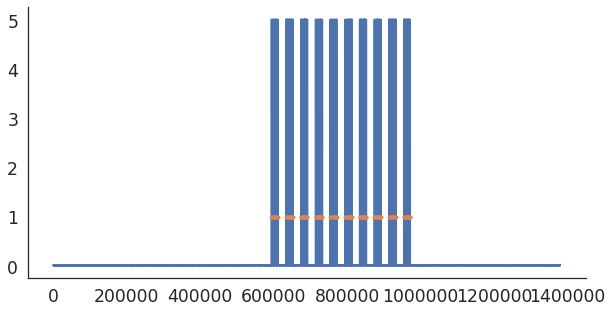

In [46]:
exp_obj = ao.alloptical(paths[0], stim='2pstim')
for key, values in vars(exp_obj).items():
    print(key)

exp_obj._parseNAPARMgpl()
exp_obj._parseNAPARMxml()
exp_obj._parsePVMetadata()
exp_obj.stimProcessing(stim_channel='markpoints2packio')

In [47]:
exp_obj.n_frames

148799

In [48]:
bad_frames = []
for j in exp_obj.stim_start_frames[0]:
    for i in range(exp_obj.duration_frames+1): # usually need to remove 1 more frame than the stim duration, as the stim isn't perfectly aligned with the start of the imaging frame
        bad_frames.append(j+i)

np.save((tiff_loc + '/bad_frames.npy'), bad_frames)   # save to npy file and remember to move npy file to tiff folder before running with suite2p

print('/// New frame total:', exp_obj.n_frames-len(bad_frames), 'frames ///')

/// New frame total: 148553 frames ///


In [49]:
exp_obj.stim_start_frames

[array([ 46,  47,  48,  49,  51,  53,  54,  56,  57,  59,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  86,  87,  88,  89, 106, 107, 108,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 136, 137, 138,
        139, 140, 142, 144, 145, 146, 147, 148, 150, 166, 167, 169, 171,
        172, 173, 174, 175, 176, 178, 179, 196, 198, 199, 201, 202, 203,
        204, 205, 206, 207, 208, 209, 210, 226, 227, 228, 229, 230, 231,
        233, 234, 235, 236, 237, 238, 239, 240, 256, 258, 259, 261, 262,
        263, 264, 266, 267, 269, 270, 286, 287, 289, 290, 291, 292, 293,
        295, 296, 297, 298, 299, 300, 317, 318, 319, 320, 321, 322, 323,
        324, 325, 326, 327, 328, 330])]

In [50]:
### make a new tiff file (not for suite2p) with the first photostim frame whitened, and save new tiff
tiff_path = tiff_loc2
import tifffile as tf
im_stack1 = tf.imread(tiff_path) 
im_stack = tf.imread(tiff_path, key=range(im_stack1.shape[0])) # hacking this a little right now here.. should really be coming from exp_obj.n_frames

frames_to_whiten = []
for j in exp_obj.stim_start_frames[0]:
        frames_to_whiten.append(j)

im_stack_1 = im_stack
a = np.full_like(im_stack_1[0], fill_value=1001.01)
for frame in frames_to_whiten:
    im_stack_1[frame] = a

frames_to_remove = []
for j in exp_obj.stim_start_frames[0]:
    for i in range(1, exp_obj.duration_frames+1): # usually need to remove 1 more frame than the stim duration, as the stim isn't perfectly aligned with the start of the imaging frame
        frames_to_remove.append(j+i)

im_stack_1 = np.delete(im_stack, frames_to_remove, axis=0)

tf.imwrite((tiff_loc + '/2020-02-26_XM002_t-009_artifactrem.tif'), im_stack_1, photometric='minisblack')




In [ ]:
# find the frames which are now photostim frames (relative to the new length after frames removed)
new_tiff = "/home/pshah/mnt/qnap/Data/2020-02-17/2020-02-17_t-005/2020-02-17_t005_artifactrem.tif"
new_stack = tf.imread(new_tiff, key=(range(len(im_stack_1))))

new_photostim_frames = []
for i in range(len(new_stack)):
    if new_stack[i][0][0]==1001:
        new_photostim_frames.append(i)
        
len(new_photostim_frames)